## Stayze Rent Prediction

In [1]:
#import modules
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [2]:
!brew install libomp

To reinstall 12.0.0, run:
  brew reinstall libomp


## Load the train data and view

In [3]:
data_train=pd.read_csv('/Users/neha/Desktop/Pragra/Grey_Atom_Tasks/Hackathon_20_Apr_21/data/Train.csv')
data_train.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,5728806,Large private room in Nolita,4271676,Nat,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,2015-09-01,0.06,3,0
1,2243769,Super Bowl New York City Apartment,11460768,Brian,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,NaN,1,0
2,35515415,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,267193767,Jenny,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,2019-07-05,4.00,1,365
3,36202006,Stream-Pressed Paradise (Laundry Room Setup),43392243,Rita,Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,NaN,4,82
4,3780951,Charming Harlem apartment,16065171,Gina,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,2019-05-26,0.27,1,365


## Check the statistical properties of the data

In [4]:
print(data_train.describe())
print("---------------------------------------------------------------------------------------------------------")
print(data_train.info())

                 id       host_id      latitude     longitude         price  \
count  3.422600e+04  3.422600e+04  34226.000000  34226.000000  34226.000000   
mean   1.898209e+07  6.733847e+07     40.729059    -73.952070    153.480979   
std    1.097597e+07  7.833091e+07      0.054604      0.046161    243.312608   
min    2.595000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.460366e+06  7.824440e+06     40.690040    -73.983150     69.000000   
50%    1.965371e+07  3.065628e+07     40.722995    -73.955700    107.000000   
75%    2.908201e+07  1.074344e+08     40.763200    -73.935982    175.000000   
max    3.648724e+07  2.743115e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    34226.000000       34226.000000       27244.000000   
mean         6.953690          23.390931           1.377074   
std         20.255833          44.476822           1.688953   
min          1.000000           0.00

## Parse 'last_review' column as its a date

In [5]:
data_train=pd.read_csv('/Users/neha/Desktop/Pragra/Grey_Atom_Tasks/Hackathon_20_Apr_21/data/Train.csv',parse_dates=["last_review"])

In [6]:
data_train.last_review.dtype

dtype('<M8[ns]')

## Added three new columns (year, month and date) as they might have value addition to the modeling

In [7]:
data_train["reviewYear"] = data_train.last_review.dt.year
data_train["reviewMonth"] = data_train.last_review.dt.month
data_train["reviewDay"] = data_train.last_review.dt.day

## Exploratory Data Analysis

In [8]:
categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type']
numerical_columns: ['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'reviewYear', 'reviewMonth', 'reviewDay']


## Correlation between columns

In [9]:
data_train.corr()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviewYear,reviewMonth,reviewDay
id,1.000000,0.587556,0.002922,0.093288,0.010100,-0.010127,-0.320246,0.292524,0.131495,0.084583,0.405366,-0.053490,-0.021845
host_id,0.587556,1.000000,0.021635,0.128007,0.013679,-0.013519,-0.142471,0.293044,0.154071,0.199093,0.263339,-0.029777,-0.016717
latitude,0.002922,0.021635,1.000000,0.085919,0.029195,0.024725,-0.014016,-0.004404,0.018272,-0.012063,-0.016190,-0.002787,-0.002658
longitude,0.093288,0.128007,0.085919,1.000000,-0.151930,-0.063447,0.055632,0.141266,-0.114418,0.085315,0.107065,0.001377,-0.016920
price,0.010100,0.013679,0.029195,-0.151930,1.000000,0.045746,-0.048459,-0.033186,0.053688,0.083439,-0.016998,0.009643,-0.008573
minimum_nights,-0.010127,-0.013519,0.024725,-0.063447,0.045746,1.000000,-0.078890,-0.120635,0.128552,0.142466,-0.051692,-0.002491,0.004837
number_of_reviews,-0.320246,-0.142471,-0.014016,0.055632,-0.048459,-0.078890,1.000000,0.544709,-0.072643,0.176161,0.273430,-0.005295,0.026015
reviews_per_month,0.292524,0.293044,-0.004404,0.141266,-0.033186,-0.120635,0.544709,1.000000,-0.010535,0.187968,0.422793,0.003847,-0.024238
calculated_host_listings_count,0.131495,0.154071,0.018272,-0.114418,0.053688,0.128552,-0.072643,-0.010535,1.000000,0.223409,0.051535,-0.023144,0.012778
availability_365,0.084583,0.199093,-0.012063,0.085315,0.083439,0.142466,0.176161,0.187968,0.223409,1.000000,0.317387,-0.034737,0.001830


In [10]:
corr_matrix=data_train.corr()
corr_matrix['price'].sort_values(ascending= False)

price                             1.000000
availability_365                  0.083439
calculated_host_listings_count    0.053688
minimum_nights                    0.045746
latitude                          0.029195
host_id                           0.013679
id                                0.010100
reviewMonth                       0.009643
reviewDay                        -0.008573
reviewYear                       -0.016998
reviews_per_month                -0.033186
number_of_reviews                -0.048459
longitude                        -0.151930
Name: price, dtype: float64

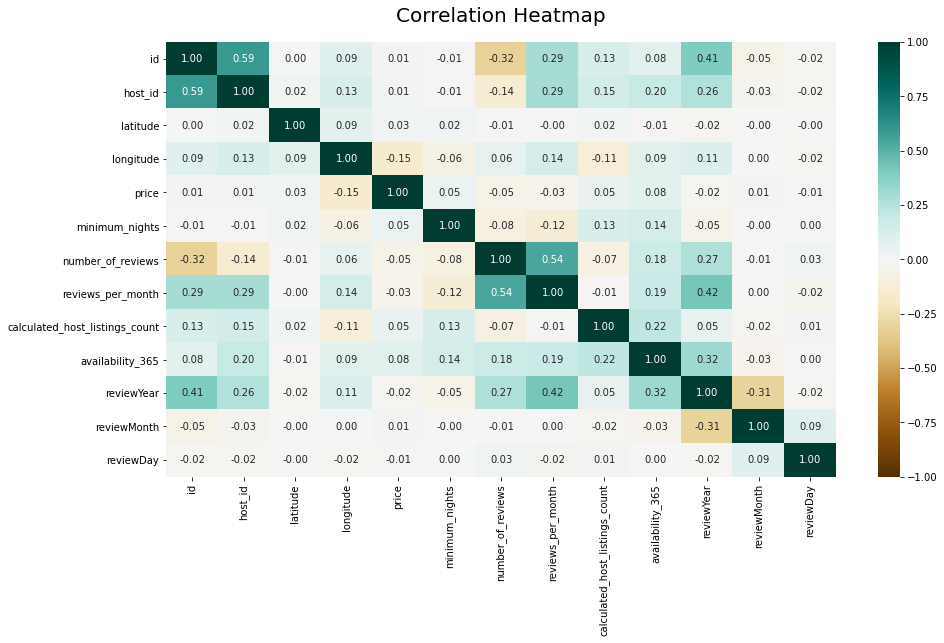

In [11]:
plt.figure(figsize=[15,8])
heatmap = sns.heatmap(data_train.corr(), vmin=-1, vmax=1,annot=True,fmt='.2f', cmap='BrBG');
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=20);

## Top 10 popular neighbourhoods

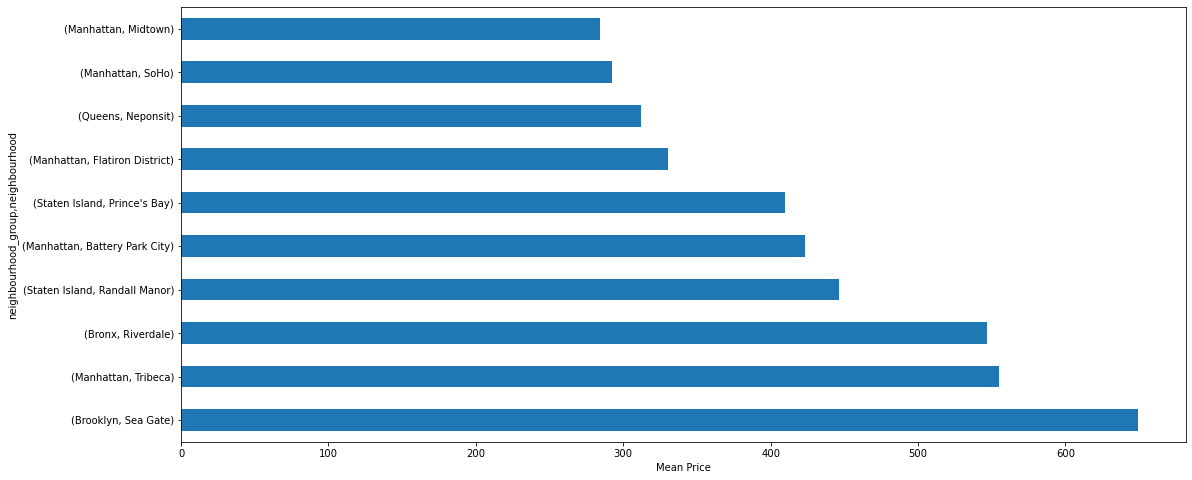

In [12]:
plt.figure(figsize=[18,8])
data_train.groupby(['neighbourhood_group','neighbourhood'])['price'].mean().sort_values(ascending=False)[:10].plot(kind='barh');
plt.xlabel('Mean Price');
plt.ylabel('neighbourhood_group,neighbourhood');
plt.savefig("neighbourhood_bar_plot.png", transparent=True)

## Distribution of listing price 

In [13]:
log_price=np.log(data_train['price'])

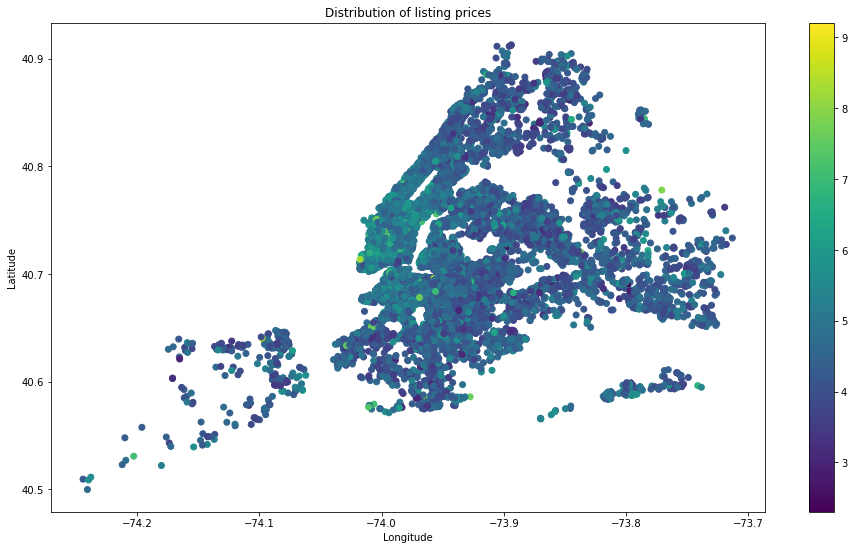

In [14]:
y = data_train.latitude
x = data_train.longitude
p = log_price
plt.figure(figsize=(16,9))
plt.scatter(x,y,c=p,cmap='viridis')
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of listing prices")
plt.show()

    ## Top 10 host with maximum reviews

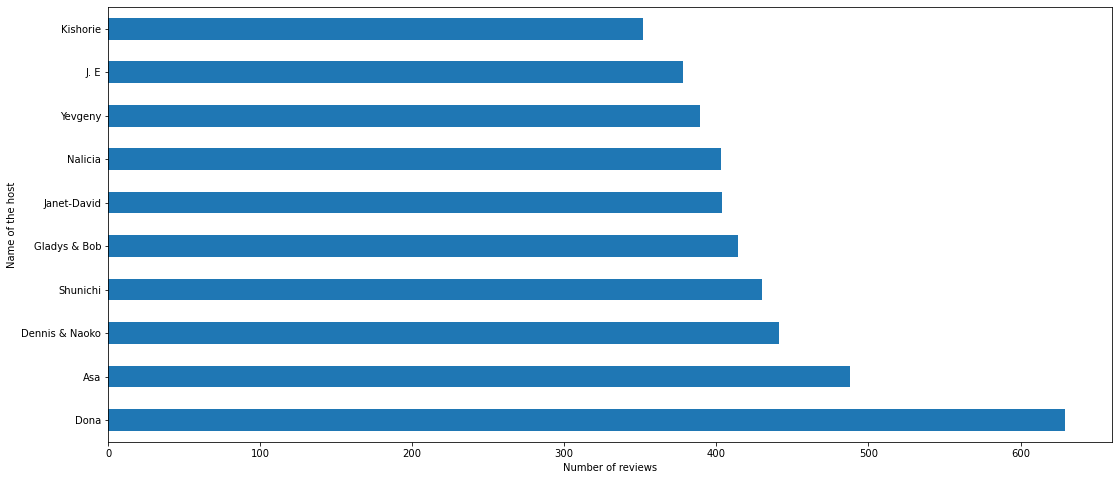

In [15]:
plt.figure(figsize=[18,8])
data_train.groupby(['host_name'])['number_of_reviews'].mean().sort_values(ascending=False)[:10].plot(kind='barh');
plt.xlabel('Number of reviews');
plt.ylabel('Name of the host');
plt.savefig("property_review_host_name_bar_plot.png", transparent=True)


## Room types count plot

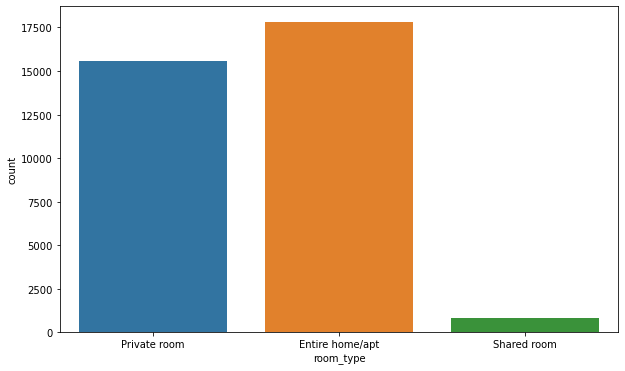

In [16]:
plt.figure(figsize=[10,6])
sns.countplot(x="room_type",data=data_train);
plt.savefig("room_type_bar_plot.png", transparent=True)

## Neighbourhood group count plot

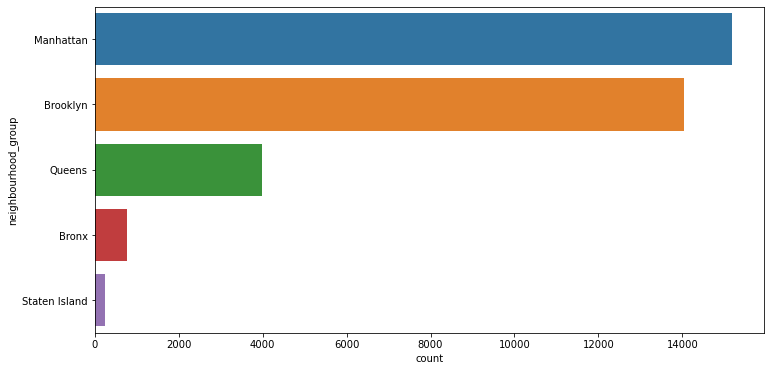

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(y='neighbourhood_group', data=data_train,order = data_train['neighbourhood_group'].value_counts().index);

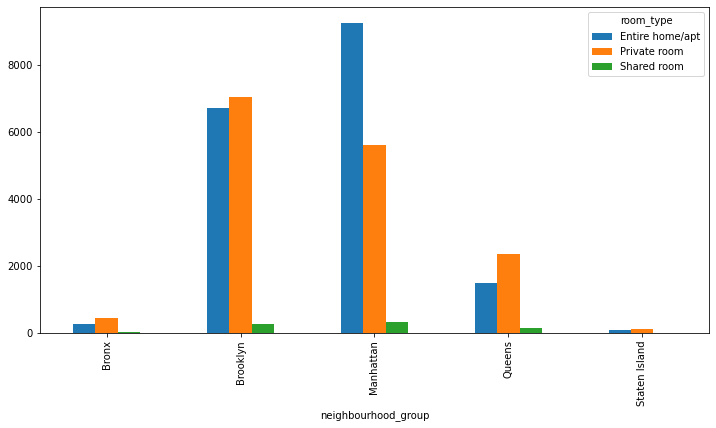

In [18]:
data_train.groupby(['neighbourhood_group','room_type']).size().unstack().plot(kind = 'bar', figsize = (12,6))
plt.savefig("neighbourhood_group_room_type_bar_plot.png", transparent=True)

## Top 10 months in which maximum reviews posted

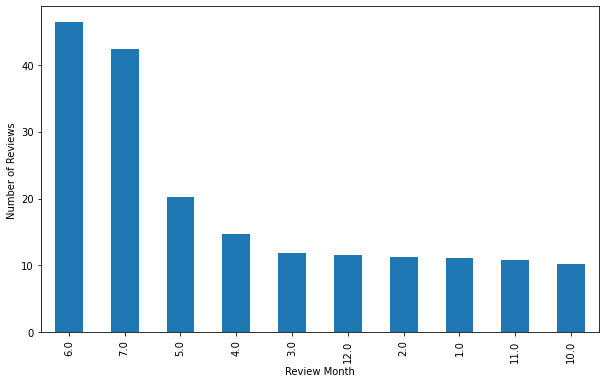

In [19]:
plt.figure(figsize=[10,6])
data_train.groupby(['reviewMonth'])['number_of_reviews'].mean().sort_values(ascending=False)[:10].plot(kind='bar');
plt.xlabel('Review Month');
plt.ylabel('Number of Reviews');
plt.savefig("review_and_month.png", transparent=True)

## Outliers

In [20]:
log_calculated= np.log(data_train['calculated_host_listings_count'])
log_minimum_nights=np.log(data_train['minimum_nights'])
log_number_of_reviews=np.log(data_train['number_of_reviews'])

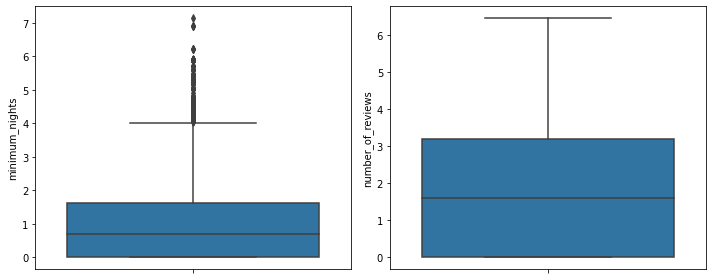

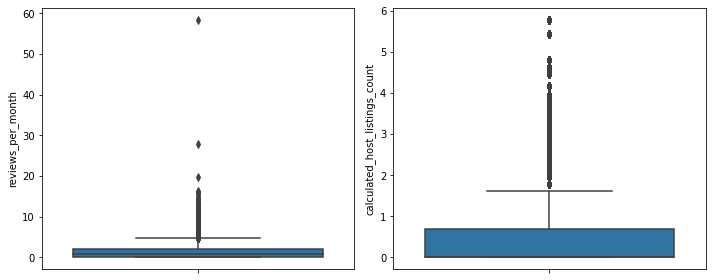

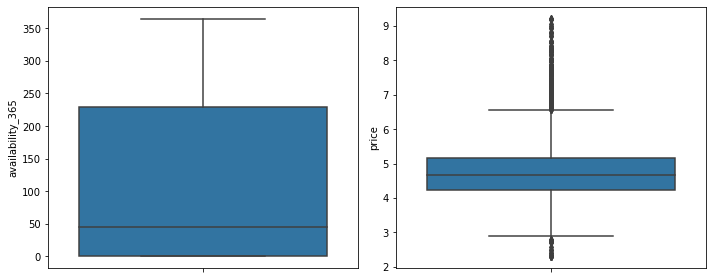

In [21]:
num_cols = [log_minimum_nights, log_number_of_reviews, 'reviews_per_month', log_calculated,'availability_365',log_price]
facet = None
for i in range(0,len(num_cols),2):
    if len(num_cols) > i+1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.boxplot(facet, num_cols[i],data = data_train)
        plt.subplot(122)            
        sns.boxplot(facet, num_cols[i+1],data = data_train)
        plt.tight_layout()
        plt.show()

    else:
        sns.boxplot(facet, num_cols[i],data = data_train)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

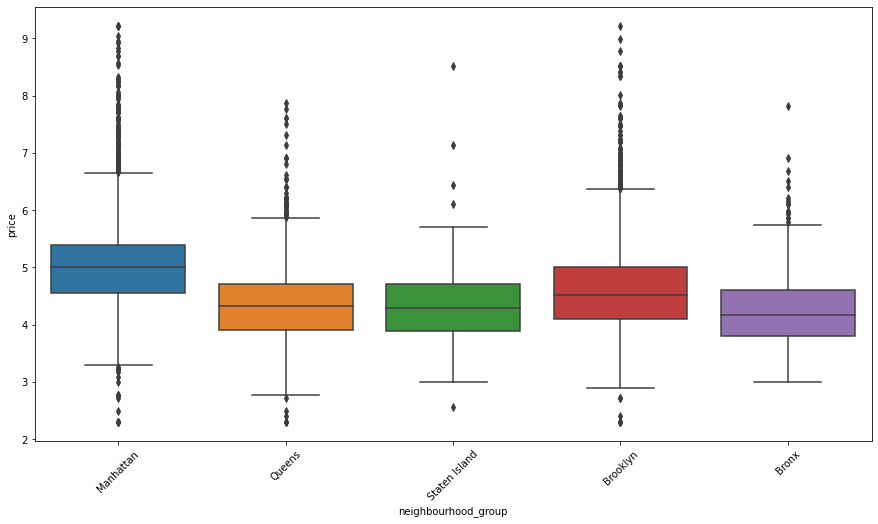

In [22]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
sns.boxplot('neighbourhood_group', log_price, data=data_train)

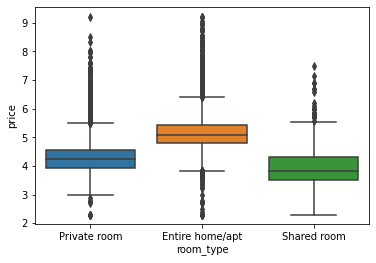

In [23]:
sns.boxplot(x="room_type",y=log_price, data=data_train)
plt.show()

## The dataset has a lot of outliers and we did remove them and tried running the models with the improved data but it did not help us improve the RMSE so we decided to skip the outliers as they change the data alot

## SKEWNESS

In [24]:
data_train.skew()

id                                -0.088312
host_id                            1.213828
latitude                           0.239973
longitude                          1.277263
price                             18.815094
minimum_nights                    23.999268
number_of_reviews                  3.645365
reviews_per_month                  3.481639
calculated_host_listings_count     7.969708
availability_365                   0.755991
reviewYear                        -1.743460
reviewMonth                        0.162742
reviewDay                         -0.083199
dtype: float64

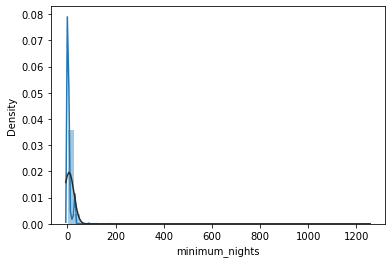

<Figure size 432x288 with 0 Axes>

In [25]:
sns.distplot(data_train['minimum_nights'], fit=norm);
fig = plt.figure()


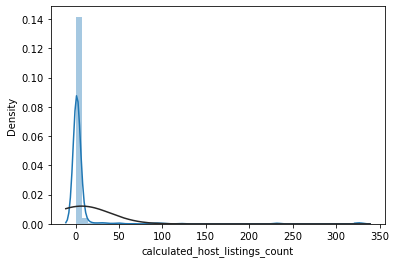

<Figure size 432x288 with 0 Axes>

In [26]:
sns.distplot(data_train['calculated_host_listings_count'], fit=norm);
fig = plt.figure()


## As we can see some of the data features are highly skewed and we tried to reduce the skewness using log and sqrt transformation. However, we noticed that the transformation did not help us in reducing the error. So in the end we decided to ignore the skewness.


## Pairplots

In [27]:
#cols = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
#sns.pairplot(data_train[cols]);

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

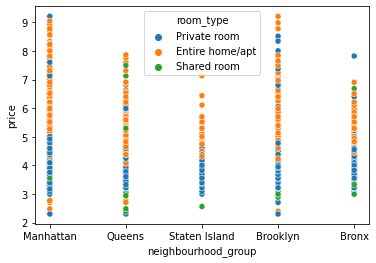

In [28]:
fig_dims = (10, 8)
sns.scatterplot(data=data_train, y=log_price, hue="room_type", x="neighbourhood_group")

## Split the train data

In [29]:
x=data_train.drop(['price'], axis=1)
y=data_train['price'].copy()
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)

In [30]:
#missing data observing in columns
total = X_train.isnull().sum(axis=0).sort_values(ascending=False)
percent = ((X_train.isnull().sum(axis=0)/X_train.isnull().count(axis=0))*100).sort_values(ascending=False)

missing_data_columns = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_columns.head(20)

,Total,Percent
reviewDay,4877,20.356457
reviewMonth,4877,20.356457
reviewYear,4877,20.356457
reviews_per_month,4877,20.356457
last_review,4877,20.356457
name,10,0.041740
host_name,8,0.033392
number_of_reviews,0,0.000000
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000


## Dropping unnecessary columns

In [31]:
X_train.drop(['id','name','host_id','last_review','reviews_per_month'],1,inplace=True)
X_val.drop(['id','name','host_id','last_review','reviews_per_month'],1,inplace=True)

## Filling missing data with median values

In [32]:
#X_train['reviews_per_month'] = X_train['reviews_per_month'].fillna(0)
X_train['reviewYear'] = X_train['reviewYear'].fillna(X_train['reviewYear'].median(),inplace=True)
X_train['reviewMonth'] = X_train['reviewMonth'].fillna(X_train['reviewMonth'].median(),inplace=True)
X_train['reviewDay'] = X_train['reviewDay'].fillna(X_train['reviewDay'].median(),inplace=True)

#X_val['reviews_per_month'] = X_val['reviews_per_month'].fillna(0)
X_val['reviewYear'] = X_val['reviewYear'].fillna(X_val['reviewYear'].median(),inplace=True)
X_val['reviewMonth'] = X_val['reviewMonth'].fillna(X_val['reviewMonth'].median(),inplace=True)
X_val['reviewDay'] = X_val['reviewDay'].fillna(X_val['reviewDay'].median(),inplace=True)

## Encoding categorical columns

In [33]:
categorical_columns = [c for c in X_train.columns 
                       if X_train[c].dtype.name == 'object']

for column in categorical_columns:
    X_train[column]=X_train[column].astype('category').cat.codes
    
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23958 entries, 10227 to 2732
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_name                       23958 non-null  int16  
 1   neighbourhood_group             23958 non-null  int8   
 2   neighbourhood                   23958 non-null  int16  
 3   latitude                        23958 non-null  float64
 4   longitude                       23958 non-null  float64
 5   room_type                       23958 non-null  int8   
 6   minimum_nights                  23958 non-null  int64  
 7   number_of_reviews               23958 non-null  int64  
 8   calculated_host_listings_count  23958 non-null  int64  
 9   availability_365                23958 non-null  int64  
 10  reviewYear                      23958 non-null  int8   
 11  reviewMonth                     23958 non-null  int8   
 12  reviewDay                    

In [34]:
categorical_columns = [c for c in X_val.columns 
                       if X_val[c].dtype.name == 'object']

for column in categorical_columns:
    X_val[column]=X_val[column].astype('category').cat.codes
    
print(X_val.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10268 entries, 33769 to 123
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_name                       10268 non-null  int16  
 1   neighbourhood_group             10268 non-null  int8   
 2   neighbourhood                   10268 non-null  int16  
 3   latitude                        10268 non-null  float64
 4   longitude                       10268 non-null  float64
 5   room_type                       10268 non-null  int8   
 6   minimum_nights                  10268 non-null  int64  
 7   number_of_reviews               10268 non-null  int64  
 8   calculated_host_listings_count  10268 non-null  int64  
 9   availability_365                10268 non-null  int64  
 10  reviewYear                      10268 non-null  int8   
 11  reviewMonth                     10268 non-null  int8   
 12  reviewDay                     

## DATA MODELING

## Linear Regression

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
rmse_linreg = np.sqrt(mean_squared_error(y_val,y_pred_lr))
print("RMSE for Linear Regression is:",rmse_linreg)

RMSE for Linear Regression is: 213.05390533627403


In [36]:
print("MAPE: ",mean_absolute_percentage_error(y_val, y_pred_lr))

MAPE:  112167538397400.02


## Random Forest Regressor

In [37]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
rmse_random_forest = np.sqrt(mean_squared_error(y_val,y_pred_rf))
print("RMSE for Random Forest Regression is:",rmse_random_forest)

RMSE for Random Forest Regression is: 212.27167333308964


In [38]:
print("MAPE: ",mean_absolute_percentage_error(y_val, y_pred_rf))

MAPE:  134572890306760.84


    ## Decision Tree Regressor

In [39]:
dt = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=2, min_samples_split=2, min_samples_leaf=2)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)
rmse_decision_tree = np.sqrt(mean_squared_error(y_val,y_pred_dt))
print("RMSE for Decision Tree is:",rmse_decision_tree)

RMSE for Decision Tree is: 214.9490889030269


## Polynominal Model

In [40]:
polynomial_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
polynomial_model.fit(X_train,y_train)
y_pred_poly = polynomial_model.predict(X_val)
rmse_poly = np.sqrt(mean_squared_error(y_val,y_pred_poly))
print("RMSE for polynomial model is:",rmse_poly)

RMSE for polynomial model is: 210.36647474556938


## Lasso Regression Model

In [41]:
from sklearn.linear_model import Lasso
model = make_pipeline(PolynomialFeatures(2), Lasso(alpha=0.01))
model.fit(X_train, y_train)
lasso_Pred = model.predict(X_val)
rmse_lasso = np.sqrt(mean_squared_error(y_val,lasso_Pred))
print("RMSE for lasso model is:",rmse_lasso);

RMSE for lasso model is: 211.6796982619687


## Ridge Regression Model

In [42]:
from sklearn.linear_model import Ridge
model = make_pipeline(PolynomialFeatures(2), Ridge(alpha=0.1))
model.fit(X_train, y_train)
ridge_Pred = model.predict(X_val)
rmse_ridge = np.sqrt(mean_squared_error(y_val,ridge_Pred))
print("RMSE for lasso model is:",rmse_ridge);

RMSE for lasso model is: 211.20030538811474


## Voting Regressor

In [43]:
clf_1 = LinearRegression()
clf_2 = XGBRegressor(random_state=4)
clf_3 = RandomForestRegressor(random_state=4)
model_list = [('lr',clf_1),('dt',clf_2),('rf',clf_3)]

voting_clf_hard = VotingRegressor(estimators=model_list)
voting_clf_hard.fit(X_train,y_train)
y_pred_vot = voting_clf_hard.predict(X_val)
rmse_voting = np.sqrt(mean_squared_error(y_val,y_pred_vot))
print("RMSE for voting regressor is:",rmse_voting)

RMSE for voting regressor is: 207.10818471514025


In [44]:
#!pip uninstall xgboost -y



In [45]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
model = LinearRegression()
grid = GridSearchCV(model,parameters)
grid.fit(X_train, y_train)
pred = grid.predict(X_val)
rmse_grid = np.sqrt(mean_squared_error(y_val,pred))
print("RMSE for polynomial model is:",rmse_grid)

RMSE for polynomial model is: 213.05390533627403


## XG Boost Model

In [46]:
xgb = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True);

xgb_grid.fit(X_train, y_train)
XGBPred = xgb_grid.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val,XGBPred))
print("RMSE for XGBoost model is:",rmse_xgb);

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[10:21:48] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE for XGBoost model is: 200.95414558945694


## Load the test data and perform the same operations as train

In [48]:
data_test = pd.read_csv("/Users/neha/Desktop/Pragra/Grey_Atom_Tasks/Hackathon_20_Apr_21/data/Test.csv",parse_dates=["last_review"])
data_test["reviewYear"] = data_test.last_review.dt.year
data_test["reviewMonth"] = data_test.last_review.dt.month
data_test["reviewDay"] = data_test.last_review.dt.day
print(data_test.head())
print(data_test.info())

         id                                               name    host_id  \
0   1525602                    Perfect Temporary Brooklyn Home    1200603   
1  30430185                        BIG APPLE - COMFY KING ROOM  224414117   
2  21354525  Cozy Brooklyn Heights Getaway w/ Manhattan Access   11743513   
3  35995074  Amazing*Quiet*Sunny*Bedroom*PrivateLivingRm*Ch...    4128829   
4  34392081  Hello! This is a very cozy space in Williamsburg.  259630588   

  host_name neighbourhood_group     neighbourhood  latitude  longitude  \
0    Andrea            Brooklyn     Crown Heights  40.66751  -73.95867   
1   Gabriel           Manhattan    Hell's Kitchen  40.75655  -73.99690   
2     Henry            Brooklyn  Brooklyn Heights  40.69252  -73.99121   
3      Sara              Queens  Ditmars Steinway  40.77292  -73.90101   
4     Alina            Brooklyn      Williamsburg  40.71863  -73.94980   

         room_type  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt     

In [ ]:
data_test.drop(['name','host_id','last_review','reviews_per_month'],1,inplace=True)
#data_test['reviews_per_month'] = data_test['reviews_per_month'].fillna(0)
data_test['reviewYear'] = data_test['reviewYear'].fillna(data_test['reviewYear'].median(),inplace=True)
data_test['reviewMonth'] = data_test['reviewMonth'].fillna(data_test['reviewMonth'].median(),inplace=True)
data_test['reviewDay'] = data_test['reviewDay'].fillna(data_test['reviewDay'].median(),inplace=True)


In [ ]:
categorical_columns = [c for c in data_test.columns 
                       if data_test[c].dtype.name == 'object']

for column in categorical_columns:
    data_test[column]=data_test[column].astype('category').cat.codes
    
print(data_test.info())

## Predict for the test data and save the result in .csv file

In [ ]:
# Storing the id from the test file
id_ = data_test['id']
data_test.drop(['id'],1,inplace=True)
# Predict on the test data
y_pred_test = xgb_grid.predict(data_test)

# Create a sample submission file
final_submission_2 = pd.DataFrame({'id':id_,'price':y_pred_test})
final_submission_2 = final_submission_2.astype(int)

# Convert the sample submission file into a csv file
final_submission_2.to_csv('final_submission_2.csv',index=False)

## Compare with the true values

In [ ]:
# read files
orignal = pd.read_csv('orignal_file.csv')
team = pd.read_csv('final_submission_2.csv')

# getting the rmse
rmse_test = np.sqrt(mean_squared_error(orignal['price'],team['price']))
print("Test RMSE is:",rmse_test);